Example notebook trying to emulate FindLCsFromOpSim.ipynb which seems to be corrupted

In [1]:
import sniacatalogs as snia
from sniacatalogs import sncat

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os


import sqlite3

In [3]:
from lsst.sims.catUtils.mixins import CosmologyMixin
from lsst.sims.utils import ObservationMetaData
from lsst.sims.catUtils.utils import ObservationMetaDataGenerator
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import eups

Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values


In [4]:
def samplePatchOnSphere(phi, theta, delta, size):
    '''
    (not) Uniformly distributes samples on a spherical patch between phi \pm delta,
    and theta \pm delta.
    
    will modify to fix this later
    Parameters
    ----------
    phi: float, mandatory, radians
        center of the spherical patch in ra with range 
    theta: float, mandatory, radians
    delta: float, mandatory, radians
    size: int, mandatory
        number of samples
    '''
    u = np.random.uniform(size=size)
    v = np.random.uniform(size=size)

    # phivals = delta * (2. * u - 1) + phi
    phivals = 2. * delta* u + (phi - delta )
    phivals = np.where ( phivals >= 0., phivals, phivals + 2. * np.pi)
    
    # use conventions in spherical coordinates
    theta = np.pi/2.0 - theta
    # thetavals = 2. * delta* v + (theta - delta )
    # thetavals = np.where ( thetavals < np.pi , thetavals, thetavals - np.pi)
    # thetavals = np.where ( thetavals > - np.pi , thetavals, thetavals + np.pi)
    
    
    thetamax = theta + delta
    thetamin = theta - delta
    # CDF is cos(thetamin) - cos(theta) / cos(thetamin) - cos(thetamax)
    a = np.cos(thetamin) - np.cos(thetamax)
    thetavals = np.arccos(-v * a + np.cos(thetamin))
    # Get back to -pi/2 to pi/2 range of decs
    thetavals = np.pi/2.0 - thetavals 
    return phivals, thetavals

In [5]:
def cleanDB(dbname, verbose=True):
    '''
    Deletes the database dbname from the disk.
    Parameters
    ----------
    dbname: string, mandatory
        name (abs path) of the database to be deleted
    verbose: Bool, optional, defaults to True

    '''

    if os.path.exists(dbname):
        if verbose:
            print "deleting database ", dbname
        os.unlink(dbname)
    else:
        if verbose:
            print 'database ', dbname, ' does not exist'

In [6]:
def sample_obsmetadata(obsmetadata, size=1):
    '''
    Sample a square patch on the sphere overlapping obsmetadata
    field of view by picking the area enclosed in
    obsmetadata.unrefractedRA \pm obsmetadata.boundLength
    obsmetadata.unrefractedDec \pm obsmetadata.boundLength

    Parameters
    ----------
    obsmetadata: instance of
        `sims.catalogs.generation.db.ObservationMetaData`

    size: integer, optional, defaults to 1
        number of samples


    Returns
    -------

    tuple of ravals, decvalues
    '''
    mydict = obsmetadata.summary
    phi = np.radians(mydict['unrefractedRA'])
    theta = np.radians(mydict['unrefractedDec'])
    equalrange = np.radians(mydict['boundLength'])
    ravals, thetavals = samplePatchOnSphere(phi=phi, theta=theta, delta=equalrange, size=size)
    return ravals, thetavals

In [7]:
def _createFakeGalaxyDB(dbname, ObsMetaData, size=10000, seed=1):
    '''
    Create a local sqlite galaxy database having filename dbname with variables
    id, raJ2000, decJ2000 and redshift, having number of rows =size, and having
    overlap with ObsMetaData.
    '''
    cleanDB(dbname)
    conn = sqlite3.connect(dbname)
    curs = conn.cursor()
    curs.execute('CREATE TABLE if not exists gals (id INT, raJ2000 FLOAT,\
                  decJ2000 FLOAT, redshift FLOAT)')

    np.random.seed(seed)
    samps = sample_obsmetadata(ObsMetaData, size=size)

    for count in range(size):
        id = 1000000 + count

        # Main Database should have values in degrees
        ra = np.degrees(samps[0][count])
        dec = np.degrees(samps[1][count])
        redshift = np.random.uniform()
        row = tuple([id, ra, dec, redshift])
        exec_str = insertfromdata(tablename='gals', records=row,
                                     multiple=False)
        curs.execute(exec_str, row)

    conn.commit()
    conn.close()
    return samps

In [8]:
def insertfromdata(tablename, records, multiple=True):
    """
    construct string to insert multiple records into sqlite3 database
    args:
        tablename: str, mandatory
            Name of table in the database.
        records: set of records
        multiple:
    returns:
    """
    if multiple:
        lst = records[0]
    else:
        lst = records
    s = 'INSERT INTO ' + str(tablename) + ' VALUES '
    s += "( " + ", ".join(["?"]*len(lst)) + ")"
    return s

In [9]:
class myGalaxyCatalog(CatalogDBObject):
    '''
    Create a like CatalogDBObject connecting to a local sqlite database
    '''

    objid = 'mytestgals'
    tableid = 'gals'
    idColKey = 'id'
    objectTypeId = 0
    appendint = 10000
    database = 'testdata/galcat.db'
    # dbAddress = './testData/galcat.db'
    raColName = 'raJ2000'
    decColName = 'decJ2000'
    driver = 'sqlite'

    # columns required to convert the ra, dec values in degrees
    # to radians again
    columns = [('id', 'id', int),
               ('raJ2000','raJ2000 * PI()/ 180. '),
               ('decJ2000','decJ2000 * PI()/ 180.'),
               ('redshift', 'redshift')]

## Now create a fake galaxy table

In [10]:
obsMetaDataforCat = ObservationMetaData(boundType='circle',
                                          boundLength=np.degrees(0.25),
                                          unrefractedRA=np.degrees(0.13),
                                          unrefractedDec=np.degrees(-1.2),
                                          bandpassName=['r'],
                                          mjd=49350.)

In [11]:
sample_obsmetadata(obsMetaDataforCat, size=1)

(array([ 0.34482643]), array([-0.95877263]))

In [12]:
obsMetaDataforCat.boundLength

14.323944878270581

In [13]:
obsMetaDataforCat._boundLength

0.25

In [14]:
vals = _createFakeGalaxyDB(dbname='testData/galcat.db',
                    ObsMetaData=obsMetaDataforCat,
                    size=1000000,
                    seed=1)

deleting database  testData/galcat.db


In [15]:
vals

(array([ 0.088511  ,  0.24016225,  6.16324249, ...,  0.12661688,
         6.21759016,  0.06512591]),
 array([-0.99399571, -1.21610453, -1.15133414, ..., -1.02888506,
        -1.33583417, -1.04711557]))

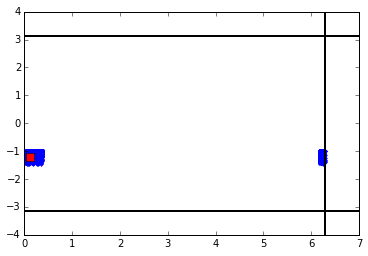

In [16]:

plt.plot(vals[0][:1000], vals[1][:1000], '.')
plt.axvline(2. * np.pi, color='k', lw=2.)
plt.axvline(0., color='k', lw=2.)
plt.axhline(np.pi, color='k', lw=2.)
plt.axhline(-np.pi, color='k', lw=2.)
plt.plot([0.13], [-1.2], 'rs', markersize=8)

In [17]:
galDB = myGalaxyCatalog()


In [18]:
class galCopy(InstanceCatalog):
    column_outputs = ['id', 'raJ2000', 'decJ2000', 'redshift']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e'}

In [19]:
galphot = galCopy(db_obj=galDB, obs_metadata=obsMetaDataforCat)


In [20]:
galphot.write_catalog('gals.dat')

In [21]:
!wc -l gals.dat

  742765 gals.dat


In [22]:
!head gals.dat

#id, raJ2000, decJ2000, redshift
1000000, 8.851100e-02, -9.939957e-01, 0.0376
1000001, 2.401622e-01, -1.216105e+00, 0.7608
1000003, 3.116629e-02, -1.009110e+00, 0.1566
1000007, 5.278036e-02, -9.771580e-01, 0.3991
1000008, 7.838374e-02, -1.024724e+00, 0.7685
1000009, 1.494084e-01, -9.881543e-01, 0.9084
1000010, 8.959726e-02, -1.070042e+00, 0.5480
1000011, 2.226098e-01, -1.132653e+00, 0.8986
1000013, 3.190587e-01, -1.084762e+00, 0.0921


## Building Light Curves from Instance Catalogs


We would like to create a number of supernova instance catalogs and then build the light curves from the catalogs. To do this correctly, we would like to use the observation_metadata associated with a number of conscutive OpSIM pointings.

In [23]:
opsimPath = os.path.join(eups.productDir('sims_data'),'OpSimData')
opsimDB = os.path.join(opsimPath,'opsimblitz1_1133_sqlite.db')

# from Tuscon AHM notebook from Scott
# This OPSIM DB is provided in sims_data. This creates a list of opsim pointings
# that I have checked. This is a tuned notebook
generator = ObservationMetaDataGenerator() #database = opsimPath, driver='sqlite')
obsMetaDataResults = generator.getObservationMetaData(limit=100,
                                                      fieldRA=(5.0, 8.0), 
                                                      fieldDec=(-85.,-60.),
                                                      expMJD=(49300., 49400.),
                                                      boundLength=0.015,
                                                      boundType='circle')


In [24]:
# How many pointings do we have? 
print (len(obsMetaDataResults))

15


In [25]:
def coords(x): 
    return np.radians(x.summary['unrefractedRA']), np.radians(x.summary['unrefractedDec'])

In [26]:
v = zip(*map(coords, obsMetaDataResults))

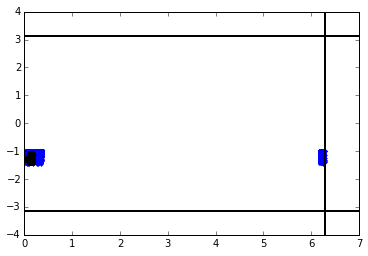

In [27]:
plt.plot(v[0], v[1], 'ko', markersize=4)
plt.plot(vals[0][:1000], vals[1][:1000], '.')
plt.axvline(2. * np.pi, color='k', lw=2.)
plt.axvline(0., color='k', lw=2.)
plt.axhline(np.pi, color='k', lw=2.)
plt.axhline(-np.pi, color='k', lw=2.)
plt.plot(v[0], v[1], 'ko', markersize=8)

In [28]:
if not os.path.exists('data/NewLightCurves'): 
    os.makedirs('data/NewLightCurves')

In [29]:
column_outputs=['flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_y',
                'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y']

In [45]:
catalog = sncat.SNIaCatalog(db_obj=galDB, 
                            obs_metadata=obsMetaDataResults[0], 
                            column_outputs=['t0', 'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z',
                                            'flux_y', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 
                                            'mag_z', 'mag_y', 'adu_u', 'adu_g', 'adu_r',
                                            'adu_i', 'adu_z', 'adu_y'])

In [46]:
catalog.suppressDimSN = False

In [ ]:
catalog.set

In [47]:
catalog.write_catalog('test_why.dat')

In [48]:
!wc -l test_why.dat

       7 test_why.dat


In [49]:
map(lambda x: obsMetaDataResults)

In [43]:
!cat test_why.dat

#snid, snra, sndec, z, t0, c, x1, x0, flux_u, flux_g, flux_r, flux_i, flux_z, flux_y, mag_u, mag_g, mag_r, mag_i, mag_z, mag_y, adu_u, adu_g, adu_r, adu_i, adu_z, adu_y
1194063, 9.807749e-02, -1.279044e+00, 0.3578, 579839.5985, -4.780265e-02, -1.5735, 2.035980e-05, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, inf, inf, inf, inf, inf, inf, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
1202620, 9.822037e-02, -1.279374e+00, 0.3552, 572811.6011, -1.076733e-01, 0.0559, 3.274857e-05, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, inf, inf, inf, inf, inf, inf, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
1456605, 9.746749e-02, -1.279057e+00, 0.7285, 581319.2605, -5.548099e-02, -1.0822, 5.384215e-06, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, inf, inf, inf, inf, inf, inf, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
1812900, 9.864307e-02, -1.279292e+00, 0.2086, 572168.1635, 4.177646e-02, 0.3476, 9.548163e-05, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, inf, inf, inf, inf, inf